In [1]:
import numpy as np
#from sko.GA import GA
import torch
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from geneticalgorithm import geneticalgorithm as ga
import math
import random
import time
from tqdm import tqdm
import seaborn as sns
import matplotlib.patches as mpatches
from datetime import datetime

start_time = time.time()

In [2]:
def read_matrix():
    # Read the csv file
    try:
        filename = input("Enter the path of the file (press Enter for default): ").strip()

        if not filename:
            filename = "flowmatrix_paper.xlsx"
            
        df = pd.read_excel(filename, header=0, index_col=0)
        header_array = df.columns.to_numpy()
        print(header_array)
        room_travel_times = df.values
        num_rows, num_cols = df.shape
        if num_rows == num_cols:
            num_rooms = num_rows
        else:
            print('matrix not complete')
            print("number of rows: ", num_rows)
            print("number of columns: ", num_cols)
            return None, None
        return room_travel_times, num_rooms, header_array
    except FileNotFoundError:
        print(f'Error: File not found. Please enter a valid file path or ensure the default file "{filename}" exists.')
        return None, None
    except pd.errors.EmptyDataError:
        print(f'Error: The file "{filename}" is empty. Please provide a non-empty file.')
        return None, None
    except pd.errors.ParserError:
        print(f'Error: Unable to parse the file "{filename}". Please ensure it is a valid CSV file.')
        return None, None
        

In [3]:
# Define Parameters

# size of the grid
Building_width = 10
Building_height = 10

N_ROWS = Building_width
N_COLS = Building_height



room_travel_times, num_rooms, header_array = read_matrix()


# Calculate travel times between rooms
travel_counts = room_travel_times + room_travel_times.T
print(travel_counts)
room_sizes = np.ones(num_rooms)
print(room_sizes)


Enter the path of the file (press Enter for default):  


['Anaesthesiology' 'Neurosurgery' 'Gynaecology' 'Otolaryngology'
 'Internal Medicine' 'Paediatrics and Adolescent Medicine' 'Neurology'
 'Orthopaedics' 'Palliative Medicine' 'Psychiatry'
 'Child and Adolescent Psychiatry' 'Urology' 'Emergency Admission'
 'Endoscopy' 'Laboratory Medicine'
 'Imaging Diagnostics and Interventional Radiological Procedures'
 'Prosecture/Pathology' 'Surgery' 'Intensive Therapy' 'Dialysis'
 'Rehabilitation Centre' 'Sterile Supply' 'Bed Preparation' 'Food Supply'
 'Maintenance and Repair']
[[0.00000e+00 0.00000e+00 6.00000e+00 1.40000e+01 1.68000e+02 0.00000e+00
  2.40000e+01 4.20000e+01 0.00000e+00 0.00000e+00 0.00000e+00 3.20000e+01
  1.20000e+01 4.00000e+00 0.00000e+00 8.80000e+01 0.00000e+00 1.20000e+02
  0.00000e+00 4.00000e+01 5.40000e+01 0.00000e+00 5.79600e+02 0.00000e+00
  2.80000e+00]
 [0.00000e+00 0.00000e+00 4.00000e+00 0.00000e+00 8.00000e+00 0.00000e+00
  1.00000e+01 4.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.0000

In [4]:
print(len(room_sizes))

25


In [5]:
def room_center(room_sizes, X):
    # get the coordinates of the room centerpoints for distance calculation
    room_centers = []

    for i in range(len(X)):
        if room_sizes[i] == 1:
            room_centers.append(X[i])
        elif room_sizes[i] == 2:
            room_centers.append([X[i][0], X[i][1] + 0.5])
        elif room_sizes[i] == 3:
            room_centers.append([X[i][0] + 0.5, X[i][1] + 0.5])

    return room_centers

In [6]:
# Room matrix Transformer
def room_mat_trans(room_sizes, X):
    X_all = []
    for i in range(len(X)):
        if room_sizes[i] == 1:
            X_all.append(X[i])
        elif room_sizes[i] == 2:
            X_all.append([X[i][0],X[i][1]])
            X_all.append([X[i][0],X[i][1]+1])
        elif room_sizes[i] == 3:
            X_all.append([X[i][0],X[i][1]])
            X_all.append([X[i][0],X[i][1]+1])
            X_all.append([X[i][0]+1,X[i][1]])
            X_all.append([X[i][0]+1,X[i][1]+1])
    return X_all


In [7]:
def calculate_distance_cityblock(room_position, room_travel_times):
    #Calculate the distance between all rooms
    room_position = torch.tensor(room_position)
    
    # Transform X from 1 dim to 2 dims
    room_position = room_position.reshape(-1,2)
    # Calculate travel times between rooms
    travel_counts = room_travel_times + room_travel_times.T

    # Calculate distance between rooms
    travel_distances = cdist(room_position, room_position, 'cityblock')

    # Calculate total travel distance
    travel_distance = np.sum(travel_distances * travel_counts)
    total_travel_distance = travel_distance.sum() / 2
    return total_travel_distance

In [8]:
# Define Constraints
def overlapping_penalty(X):
    # Transform X from 1 dim to 2 dims
    X = np.array(X).reshape(-1, 2)

    # Find unique rows and their counts
    unique_rows, counts = np.unique(X, axis=0, return_counts=True)

    # Identify indices of rows with counts greater than 1
    duplicate_indices = np.where(counts > 1)[0]

    overlapping = duplicate_indices.size  # Number of overlapping rows

    return overlapping, list(unique_rows[duplicate_indices])

In [9]:
# Calculation of vacant ratio
def vacancy(X_all):
    min_x = torch.min(X_all[:, 0])
    min_y = torch.min(X_all[:, 1])
    max_x = torch.max(X_all[:, 0])
    max_y = torch.max(X_all[:, 1])
    building_area = (max_y- min_y + 1) * (max_x - min_x + 1)
    occupied_area = X_all.shape[0]
    vacant_ratio = (building_area - occupied_area) / building_area
    return vacant_ratio

In [10]:
# Penalize the result when the rooms are out of the building
def boundary_penalty(X_all, Building_width, Building_height):
    exceed_width = torch.any(X_all[:, 0] >= Building_width)
    exceed_height = torch.any(X_all[:, 1] >= Building_height)
    if exceed_width or exceed_height:
        return 1
    else:
        return 0

In [11]:
# Fitness function
import warnings

warnings.filterwarnings('ignore')

def fitness_func(X):
    # TODO: add vacant ratio
    X = X.reshape(-1,2)
    center= room_center(room_sizes, X)
    fitness = calculate_distance_cityblock(center, room_travel_times)
    X_all = torch.tensor(room_mat_trans(room_sizes, X))
    # Check contraints
    overlapping, duplicate_rows = overlapping_penalty(X_all)
    violation = overlapping
    #print(violation)
    vacant_ratio = vacancy(X_all)
    return fitness + violation * 1e10 + vacant_ratio * 5000
    # Removed vacancy rate from the fitness function after experimentation as its inclusion resulted in poorer outcomes

In [12]:
# Set boundary of the value
varbound = np.array([(0, Building_width-1), (0, Building_height-1)] * num_rooms)

In [13]:
def plot_room_layout_object(Building_height, Building_width, x_all, room_sizes, num_rooms, header_array, center, score, transport_object):

    grid = np.zeros([Building_height, Building_width])

    color_cells = torch.round(x_all).long()
    color_cells = color_cells.reshape(-1, 2)

    colors = sns.color_palette("husl", num_rooms)

    room_sizes = np.array(room_sizes)
    insert_counts = np.where(room_sizes == 1, room_sizes - 1, room_sizes)
    insert_counts = np.where(room_sizes == 2, insert_counts - 1, insert_counts)
    insert_counts = np.where(room_sizes == 4, insert_counts - 1, insert_counts)
    insert_counts = insert_counts.reshape(-1, 1)

    new_colors = []

    now = datetime.now()
    timestamp = now.strftime("%Y%m%d_%H%M%S")

    for i, color in enumerate(colors):
        new_colors.append(color)
        for j in range(int(insert_counts[i])):
            new_colors.append(color)

    for i, cell in enumerate(color_cells):
        if 0 <= cell[0] < grid.shape[1] and 0 <= cell[1] < grid.shape[0]:
            grid[cell[1], cell[0]] = i + 1

    fig, ax = plt.subplots()
    ax.imshow(grid, cmap='binary', origin='lower')

    fig.set_size_inches(10, 8)

    ax.set_title(f'Ideal Layout', fontsize=16, fontweight='bold')
    ax.set_xlabel('Length', fontsize=12)
    ax.set_ylabel('Width', fontsize=12)
    ax.tick_params(labelsize=10)

    ax.set_xticks(np.arange(-0.5, Building_width, 1))
    ax.set_yticks(np.arange(-0.5, Building_height, 1))
    ax.set_xticklabels(np.arange(0, Building_width + 1, 1))
    ax.set_yticklabels(np.arange(0, Building_height + 1, 1))

    for i, cell in enumerate(color_cells):
        ax.add_patch(plt.Rectangle((cell[0] - 0.5, cell[1] - 0.5), 1, 1, fill=True, color=new_colors[i]))

    for i, cell in enumerate(center):
        ax.text(cell[0], cell[1], str(i + 1), color='black', ha='center', va='center', fontsize=12)

    handles = [mpatches.Patch(color=c, label=str(i + 1) + ": " + header_array[i]) for i, c in enumerate(colors)]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax.grid(color='black', linewidth=1)

    plt.tight_layout()
    filename = f'ideallayout_{transport_object}_{timestamp}.png'
    fig.savefig(filename, bbox_inches='tight', dpi=1600)
    plt.show()


In [14]:
def plot_room_layout(Building_height, Building_width, x_all, room_sizes, num_rooms, header_array, center, score, elite_ratio, num_iteration, population_size):

    grid = np.zeros([Building_height, Building_width])


    color_cells = torch.round(x_all).long()
    color_cells = color_cells.reshape(-1, 2)


    colors = sns.color_palette("husl", num_rooms)


    room_sizes = np.array(room_sizes)
    insert_counts = np.where(room_sizes == 1, room_sizes - 1, room_sizes)
    insert_counts = np.where(room_sizes == 2, insert_counts - 1, insert_counts)
    insert_counts = np.where(room_sizes == 4, insert_counts - 1, insert_counts)
    insert_counts = insert_counts.reshape(-1, 1)

    new_colors = []


    for i, color in enumerate(colors):
        new_colors.append(color)
        for j in range(int(insert_counts[i])):
            new_colors.append(color)


    for i, cell in enumerate(color_cells):
        if 0 <= cell[0] < grid.shape[1] and 0 <= cell[1] < grid.shape[0]:
            grid[cell[1], cell[0]] = i + 1


    fig, ax = plt.subplots()
    ax.imshow(grid, cmap='binary', origin='lower')


    fig.set_size_inches(10, 8)


    ax.set_title(f'Room Layout (fitness score: {score})', fontsize=16, fontweight='bold')
    ax.set_xlabel('Length', fontsize=12)
    ax.set_ylabel('Width', fontsize=12)
    ax.tick_params(labelsize=10)


    ax.set_xticks(np.arange(-0.5, Building_width, 1))
    ax.set_yticks(np.arange(-0.5, Building_height, 1))
    ax.set_xticklabels(np.arange(0, Building_width + 1, 1))
    ax.set_yticklabels(np.arange(0, Building_height + 1, 1))


    for i, cell in enumerate(color_cells):
        ax.add_patch(plt.Rectangle((cell[0] - 0.5, cell[1] - 0.5), 1, 1, fill=True, color=new_colors[i]))

    for i, cell in enumerate(center):
        ax.text(cell[0], cell[1], str(i + 1), color='black', ha='center', va='center', fontsize=12)


    handles = [mpatches.Patch(color=c, label=str(i + 1) + ": " + header_array[i]) for i, c in enumerate(colors)]
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax.grid(color='black', linewidth=1)


    plt.tight_layout()
    filename = f'ideallayout_elite_{elite_ratio}_iter_{num_iteration}_population_{population_size}.png'
    fig.savefig(filename, bbox_inches='tight', dpi=1600)
    plt.show()


 The best solution found:                                                                           
 [7. 3. 7. 4. 5. 5. 4. 5. 4. 3. 6. 3. 4. 2. 6. 2. 5. 1. 5. 6. 2. 3. 3. 2.
 3. 4. 3. 3. 3. 5. 5. 2. 4. 1. 5. 4. 6. 4. 4. 4. 7. 2. 4. 6. 5. 3. 6. 5.
 2. 4.]

 Objective function:
 698837.7777777776


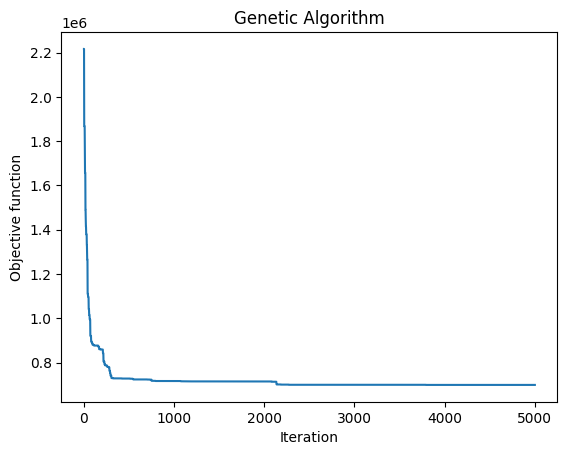

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]


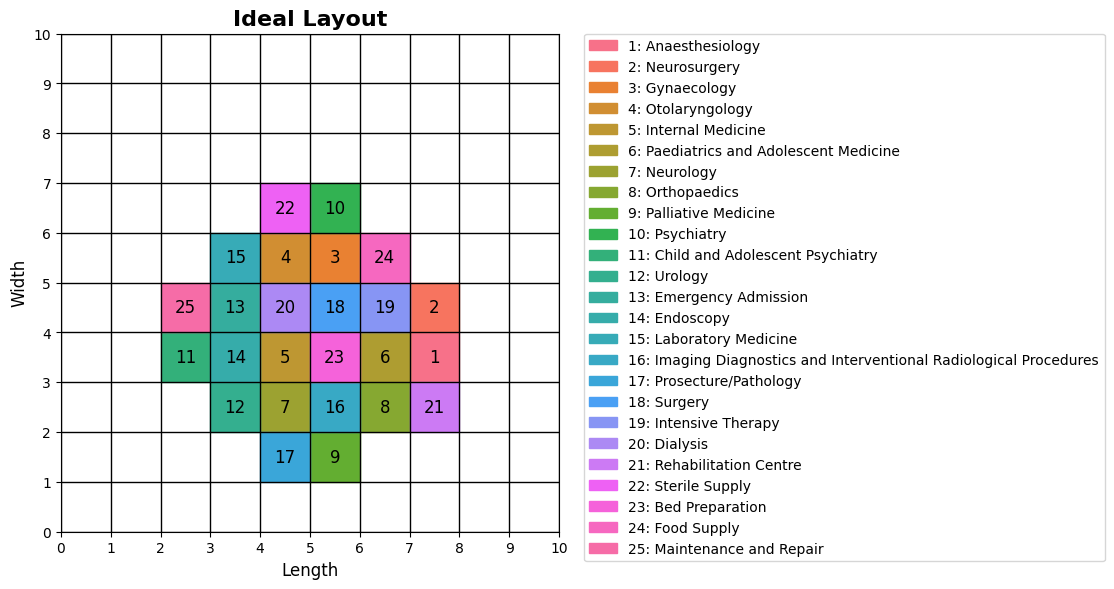

In [15]:
room_sizes = np.ones(num_rooms)
for i in range(1):
    X = []
    x_all = 0
    # Set the parameters for the Genetic Algorithm
    algorithm_param = {'max_num_iteration': 5000,\
                       'population_size':100,\
                       'mutation_probability':0.1,\
                       'elit_ratio': 0.09,\
                       'crossover_probability': 0.5,\
                       'parents_portion': 0.3,\
                       'crossover_type':'uniform',\
                       'max_iteration_without_improv':3000}
    
    model=ga(function=fitness_func,\
                dimension=num_rooms*2,\
                variable_type='int',\
                variable_boundaries=varbound,\
                algorithm_parameters=algorithm_param)
    
    model.run()
    solution=model.output_dict
    X = solution["variable"]
    
    X = X.reshape(-1,2)
    score = solution['function']
    center= room_center(room_sizes, X)
    x_all = room_mat_trans(room_sizes, X)
    x_all = torch.tensor(x_all)

    grid = np.zeros((Building_width+1, Building_height+1))
    

    room_sizes = np.where(room_sizes == 3, 4, room_sizes)
    split_indices = np.cumsum(room_sizes)[:-1]
    print(split_indices)
    

    colors = sns.color_palette("husl", num_rooms)
    plot_room_layout_object(Building_height, Building_width, x_all, room_sizes, num_rooms, header_array, center, score, "all")
    np.savetxt(f"ideal_layout_{score}.txt", x_all, fmt="%.2f")


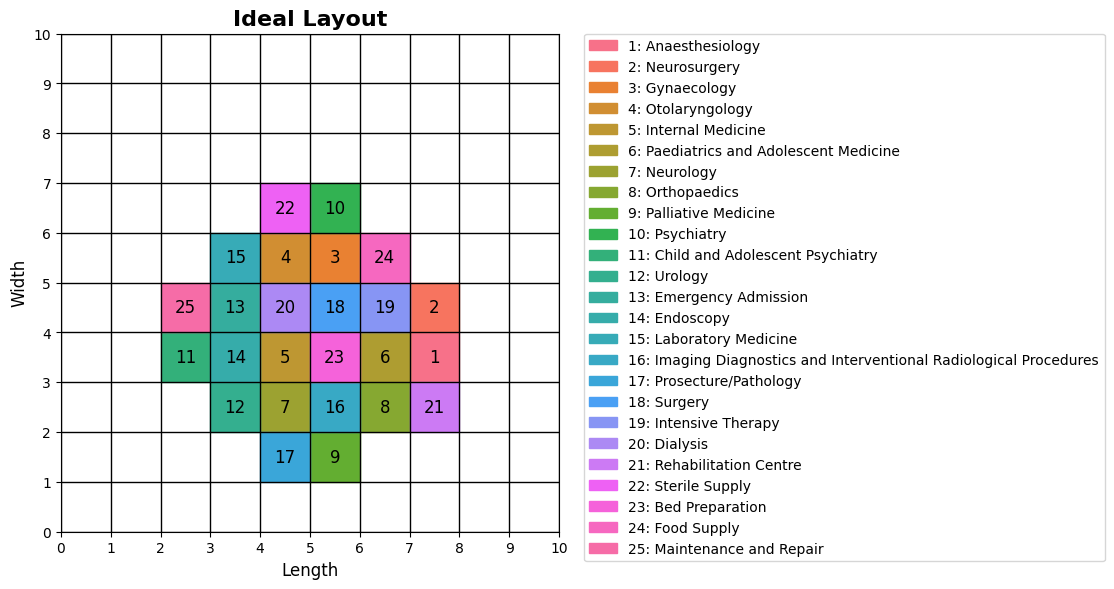

In [16]:
plot_room_layout_object(Building_height, Building_width, x_all, room_sizes, num_rooms, header_array, center, score, "all")

In [17]:
print(x_all)

tensor([[7., 3.],
        [7., 4.],
        [5., 5.],
        [4., 5.],
        [4., 3.],
        [6., 3.],
        [4., 2.],
        [6., 2.],
        [5., 1.],
        [5., 6.],
        [2., 3.],
        [3., 2.],
        [3., 4.],
        [3., 3.],
        [3., 5.],
        [5., 2.],
        [4., 1.],
        [5., 4.],
        [6., 4.],
        [4., 4.],
        [7., 2.],
        [4., 6.],
        [5., 3.],
        [6., 5.],
        [2., 4.]], dtype=torch.float64)


In [18]:
np.savetxt(f"ideal_layout_{score}.txt", x_all, fmt="%.2f")